Data shape: (23544, 2792)
Computed pos_weight shape: torch.Size([2792])
Epoch [1/50] Train Loss: 1.7735 | Val Loss: 1.4292
Epoch [2/50] Train Loss: 1.2402 | Val Loss: 1.5451
Epoch [3/50] Train Loss: 1.1427 | Val Loss: 1.6384
Epoch [4/50] Train Loss: 1.1075 | Val Loss: 1.6200
Epoch [5/50] Train Loss: 1.0720 | Val Loss: 1.6273
Epoch [6/50] Train Loss: 1.0509 | Val Loss: 1.7461
Epoch [7/50] Train Loss: 1.0373 | Val Loss: 1.7796
Epoch [8/50] Train Loss: 1.0265 | Val Loss: 1.8660
Epoch [9/50] Train Loss: 1.0119 | Val Loss: 1.8104
Epoch [10/50] Train Loss: 1.0057 | Val Loss: 1.6696
Epoch [11/50] Train Loss: 0.9904 | Val Loss: 1.8693
Epoch [12/50] Train Loss: 0.9757 | Val Loss: 1.9682
Epoch [13/50] Train Loss: 0.9633 | Val Loss: 1.9479
Epoch [14/50] Train Loss: 0.9584 | Val Loss: 1.9171
Epoch [15/50] Train Loss: 0.9455 | Val Loss: 1.9351
Epoch [16/50] Train Loss: 0.9387 | Val Loss: 1.8087
Epoch [17/50] Train Loss: 0.9340 | Val Loss: 1.9414
Epoch [18/50] Train Loss: 0.9161 | Val Loss: 1.9716
E

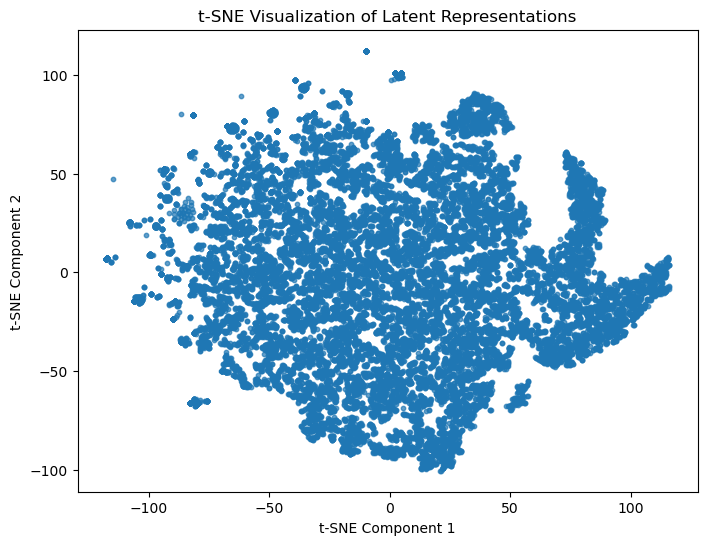

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1) LOAD & PREPROCESS DATA
# ---------------------------------------------
def load_mutation_data(csv_path):
    # Load CSV file
    df = pd.read_csv(csv_path)
    # Keep only the Patient column and the mutation columns (adjust column indices as needed)
    df = df.iloc[:, [0] + list(range(263, len(df.columns) - 2))]
    
    # Extract patient IDs
    patient_ids = df['Patient'].values
    # Get binary mutation features; convert to float32 for PyTorch
    X = df.drop(columns='Patient').values.astype(np.float32)
    return X, patient_ids

# ---------------------------------------------
# 2) COMPUTE WEIGHTED LOSS FACTOR (POS_WEIGHT)
# ---------------------------------------------
def compute_pos_weight(X):
    """
    Compute per-feature positive weight as (# negatives) / (# positives).
    To avoid division by zero, add a small epsilon.
    """
    eps = 1e-6
    # X is (num_samples, num_features)
    num_positives = np.sum(X, axis=0)
    num_negatives = X.shape[0] - num_positives
    pos_weight = num_negatives / (num_positives + eps)
    return torch.tensor(pos_weight, dtype=torch.float32)

# ---------------------------------------------
# 3) DEFINE THE AUTOENCODER MODEL
# ---------------------------------------------
class MutationAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super(MutationAutoencoder, self).__init__()
        # ENCODER: input_dim -> 512 -> 256 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, latent_dim)
        )
        # DECODER: latent_dim -> 256 -> 512 -> input_dim
        # Note: We do NOT apply a final Sigmoid here because BCEWithLogitsLoss expects logits.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, input_dim)
            # We do not use Sigmoid here as BCEWithLogitsLoss applies sigmoid internally.
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon_logits = self.decoder(z)
        return x_recon_logits

# ---------------------------------------------
# 4) DEFINE A CUSTOM DATASET
# ---------------------------------------------
class MutationDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X)  # shape: [num_samples, num_features]

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        # Autoencoder: input is also target.
        return self.X[idx], self.X[idx]

def make_dataloaders(X, train_ratio=0.8, batch_size=32):
    dataset = MutationDataset(X)
    n = len(dataset)
    n_train = int(train_ratio * n)
    n_val = n - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ---------------------------------------------
# 5) TRAINING & EVALUATION LOOP
# ---------------------------------------------
def train_autoencoder(model, train_loader, val_loader, pos_weight, 
                      num_epochs=50, lr=1e-3, device='cpu'):
    model.to(device)
    # Use BCEWithLogitsLoss with the computed pos_weight.
    # pos_weight should be of shape (input_dim,)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_target in train_loader:
            batch_x = batch_x.to(device)
            batch_target = batch_target.to(device)
            # Forward pass: note that model returns logits.
            logits = model(batch_x)
            loss = criterion(logits, batch_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch_x)
        avg_train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_target in val_loader:
                batch_x = batch_x.to(device)
                batch_target = batch_target.to(device)
                logits = model(batch_x)
                loss = criterion(logits, batch_target)
                val_loss += loss.item() * len(batch_x)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print("Training complete.")

# ---------------------------------------------
# 6) VISUALIZE LATENT REPRESENTATIONS WITH t-SNE
# ---------------------------------------------
def visualize_latent(model, dataset, device='cpu'):
    model.eval()
    latent_list = []
    with torch.no_grad():
        loader = DataLoader(dataset, batch_size=32, shuffle=False)
        for batch_x, _ in loader:
            batch_x = batch_x.to(device)
            z = model.encoder(batch_x)
            latent_list.append(z.cpu().numpy())
    latent_all = np.concatenate(latent_list, axis=0)
    print("Latent shape:", latent_all.shape)
    
    # Use t-SNE to reduce latent dimensions to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_all)
    
    plt.figure(figsize=(8,6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.7)
    plt.title("t-SNE Visualization of Latent Representations")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    # save plot
    plt.savefig("../fig/latent_tsne.png")
    plt.show()

# ---------------------------------------------
# 7) MAIN: TRAIN MODEL, SAVE LATENT, VISUALIZE
# ---------------------------------------------
if __name__ == "__main__":
    # Load data
    csv_path = "../data/msk_2024_mutations_final.csv"
    X, patient_ids = load_mutation_data(csv_path)
    print("Data shape:", X.shape)

    # Compute the positive weight per feature (for weighted loss)
    pos_weight = compute_pos_weight(X)
    print("Computed pos_weight shape:", pos_weight.shape)

    # Create dataloaders
    train_loader, val_loader = make_dataloaders(X, train_ratio=0.8, batch_size=32)

    # Initialize the autoencoder model
    input_dim = X.shape[1]
    latent_dim = 64  # Adjust latent dimension as needed
    model = MutationAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Train the autoencoder using weighted BCE loss
    train_autoencoder(model, train_loader, val_loader, pos_weight, 
                      num_epochs=50, lr=1e-3, device=device)

    # After training, extract the latent representations for the entire dataset.
    full_dataset = MutationDataset(X)
    model.eval()
    all_latents = []
    with torch.no_grad():
        full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)
        for batch_x, _ in full_loader:
            batch_x = batch_x.to(device)
            z = model.encoder(batch_x)
            all_latents.append(z.cpu().numpy())
    all_latents = np.concatenate(all_latents, axis=0)  # (num_samples, latent_dim)
    
    # Save latent representations along with patient IDs to CSV.
    latent_cols = [f"latent_{i}" for i in range(latent_dim)]
    latent_df = pd.DataFrame(all_latents, columns=latent_cols)
    latent_df.insert(0, "Patient", patient_ids)
    latent_df.to_csv("latent_representations.csv", index=False)
    print("Saved latent representations to 'latent_representations.csv'.")

    # Visualize the latent space using t-SNE.
    visualize_latent(model, full_dataset, device=device)
